# Test of Doppler lags for the observed oscillations

Following tests are scripted for comprehensive characterization
- convergence to reference orbit with zero lags
- impact of a uniform lag in the Doppler (range rate) data
- impact of light-time lags, i.e., radial acceleration and light time
- impact of light-time lags times a scale factor


In [1]:
from astropy import units as u
sampling_interval = 1*u.minute
tracking_period = 5*u.day

In [2]:
from astropy import constants as const
from astropy import visualization
from astropy.coordinates import solar_system_ephemeris

from poliastro.util import norm
from poliastro.twobody.sampling import EpochsArray

import numpy as np
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sim.stations import dss25, dss34
from sim.tracking import Tracking
from sim.util import orbit_from_horizons, make_epochs, find_rates
from sim.util import describe_orbit, describe_trajectory, plot_residual, plot_swings
from sim.fitorbit import OrbitFitter

def plots(epochs, residual, title, ylab):
    plot_residual(epochs, residual, title, 'Residual ' + ylab)
    try:
        plot_swings(epochs, residual, None, 'Residual swings ' + ylab)
    except ValueError:
        # no swings identified
        pass

def fitv(ref_orbit, ref_stations, epochs, sim_meas, title, _trace=False):
    fitter = OrbitFitter(ref_orbit, ref_stations, trace=_trace)
    fitter.fit_doppler_data(epochs, sim_meas)
    print(fitter.report())
    print('Time elapsed (hh:mm:ss.ms) {}'.format(fitter.runtime))
    describe_orbit(fitter.orbit)
    plots(epochs, fitter.result.residual, title, 'doppler (m/s)')
    return fitter

def reusefitv(fitsolution, epochs, sim_meas, title):
    residual = fitsolution.doppler_residual(epochs, sim_meas)
    plots(epochs, residual, title, 'doppler (m/s)')
    return residual

def fitr(ref_orbit, ref_stations, epochs, sim_meas, title, _trace=False):
    fitter = OrbitFitter(ref_orbit, ref_stations, trace=_trace)
    fitter.fit_range_data(epochs, sim_meas)
    print(fitter.report())
    print('Time elapsed (hh:mm:ss.ms) {}'.format(fitter.runtime))
    describe_orbit(fitter.orbit)
    plots(epochs, fitter.result.residual, title, 'range (m)')
    rates = find_rates(epochs, fitter.result.residual)
    plots(epochs[1:], rates, None, 'range rate (m/s)')
    return fitter, rates

def reusefitr(fitsolution, epochs, sim_meas, title):
    residual = fitsolution.range_residual(epochs, sim_meas)
    plots(epochs, residual, title, 'range (m)')
    rates = find_rates(epochs, residual)
    plots(epochs[11:], rates[10:], None, 'range rate (m/s)')
    return rates

In [3]:
solar_system_ephemeris.set("de440")
goldstone_end = Tracking.NEAR_GOLDSTONE_END.value

near_goldstone_orbit = orbit_from_horizons("NEAR", goldstone_end)
describe_orbit(near_goldstone_orbit)


::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437.250829758486 km
Semimajor axix: -8494.322039490264 km
Periapse radius: 6908.917068596319 km , altitude: 530.7804685963192 km


In [4]:
canberra_start = Tracking.NEAR_CANBERRA_START.value
canberra_end = canberra_start + tracking_period
epochs = make_epochs(canberra_start, canberra_end, sampling_interval)
print("Start and end:", epochs[0], epochs[-1], "[", epochs.size, "]")

near_extended_ephem = near_goldstone_orbit.to_ephem(EpochsArray(epochs))
describe_trajectory(near_extended_ephem, dss34)

Start and end: 1998-01-23 09:53:55.600 1998-01-28 09:52:55.600 [ 7200 ]

::TRAJECTORY::
Start and end ranges: 73585.03676543989 km 3060221.5565154376 km
Start and end radial speeds: 7.3216176182785535 km / s 6.7661642567094855 km / s
Closest: 73145.82143191747 km speed 7.5891622264313146 km / s  at  1998-01-23 09:53:55.600
Deflection: 0.45760597068390957 deg


In [5]:
vdata_ref = []
vlags = []
vlags_full = []
vdata_constvlags = []
vdata_ltlags_full = []
vdata_ltlags = []
vdata_scaledlags = []

rdata_ref = []
rlags = []
rlags_full = []
rdata_constrlags = []
rdata_ltlags_full = []
rdata_ltlags = []
rdata_scaledlags = []

scalefactor = 0.1
first_vlag = None
first_rlag = None

for e in epochs[:-1]:
    ref_r, ref_rr, ref_ra, ref_rs = dss34.range_rate_accel(near_extended_ephem, e)

    vlag_full = ref_ra*ref_r/const.c
    vlag = (ref_ra+ref_rs)*ref_r/const.c

    if first_vlag is None:
        first_vlag = vlag

    vlags.append(vlag)
    vlags_full.append(vlag_full)

    vdata_ref.append([ref_rr])
    vdata_constvlags.append([ref_rr - first_vlag])
    vdata_ltlags_full.append([ref_rr - vlag_full])
    vdata_ltlags.append([ref_rr - vlag])
    vdata_scaledlags.append([ref_rr - scalefactor*vlag])

for e in epochs:
    rv = near_extended_ephem.rv(e)
    ref_r, ref_rr, ref_rs = dss34.range_and_rates(rv, e)

    rlag_full = ref_rr*ref_r/const.c
    rlag = (ref_rr+ref_rs)*ref_r/const.c

    if first_rlag is None:
        first_rlag = rlag

    rlags.append(rlag)
    rlags_full.append(rlag_full)

    rdata_ref.append([ref_r])
    rdata_constrlags.append([ref_r - first_rlag])
    rdata_ltlags_full.append([ref_r - rlag_full])
    rdata_ltlags.append([ref_r - rlag])
    rdata_scaledlags.append([ref_r - scalefactor*rlag])

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 15
    # data points      = 7199
    # variables        = 6
    chi-square         = 0.00783447
    reduced chi-square = 1.0892e-06
    Akaike info crit   = -98836.8896
    Bayesian info crit = -98795.5994
##  Warning: uncertainties could not be estimated:
    a:     at initial value
    ecc:   at initial value
    inc:   at initial value
    argp:  at initial value
[[Variables]]
    a:    -8494322.04 (init = -8494322)
    ecc:   1.81335709 (init = 1.813357)
    inc:   1.88447854 (init = 1.884479)
    nu:   -1.83945963 (init = -1.839425)
    raan:  1.54001071 (init = 1.540059)
    argp:  2.53324335 (init = 2.533258)
Time elapsed (hh:mm:ss.ms) 0:12:39.066248

::ORBIT::
Plane: Planes.EARTH_EQUATOR
Inclination: 107.97266698121356 deg
Eccentricity: 1.813357091534396
Semilatus rectum: 19437250.829758488 m
Semimajor axix: -8494322.039490264 m
Periapse radius: 6908917.068596319 m , altitude: 530780.4685963197 m
[0.00

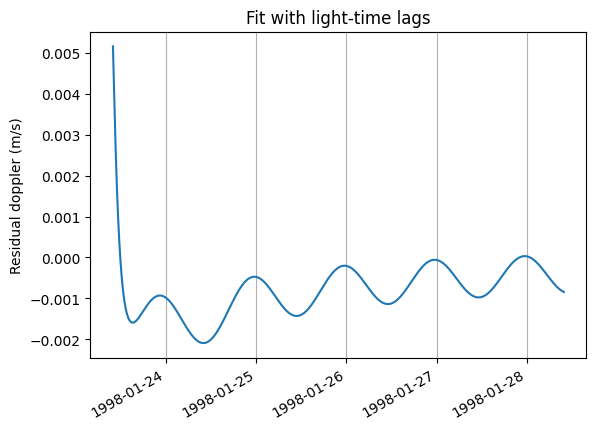

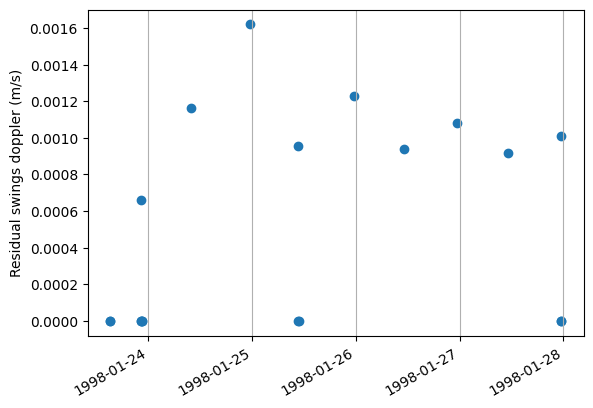

In [6]:
ltfitv = fitv(near_goldstone_orbit, [dss34], epochs[:-1], vdata_ltlags, "Fit with light-time lags")

[3.4381325046128897e-06, 4.028746237280667e-05, 1.2417634251415954e-07, 6.128102540892133e-05]


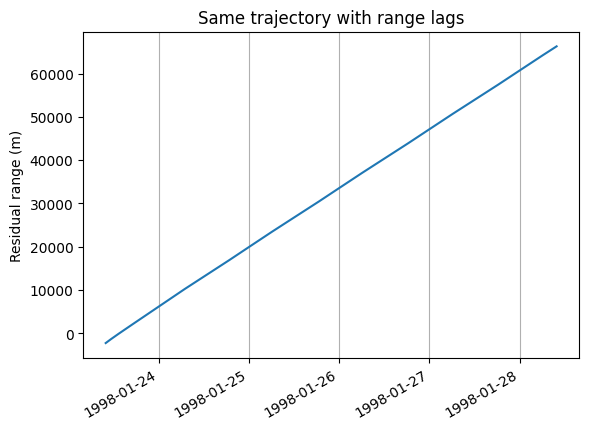

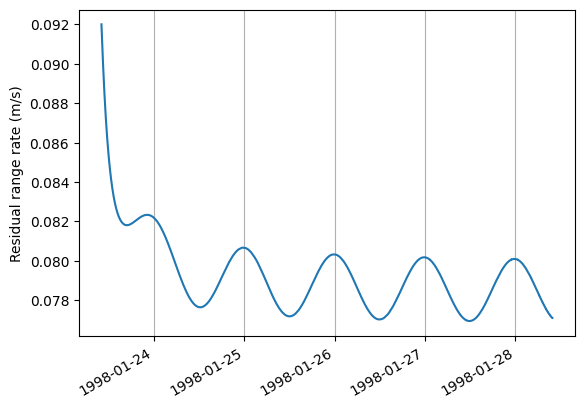

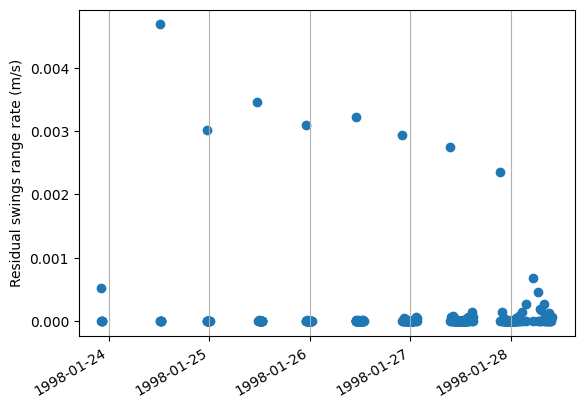

In [7]:
_ = ltresr_rates = reusefitr(ltfitv, epochs[:-1], rdata_ltlags, "Same trajectory with range lags")

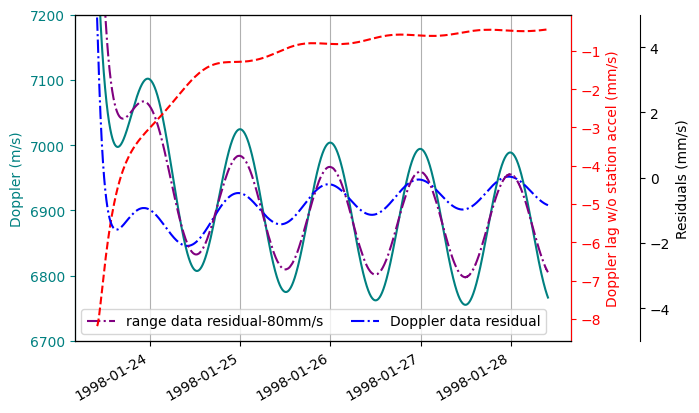

In [10]:
with visualization.time_support():
    fig, ax = plt.subplots()
    plt.xlabel('')
    plt.grid(axis='x')

    if tracking_period > 5*u.day:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
    else:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))

    ax.set_ylabel('Doppler (m/s)', color = "teal")
    ax.spines['left'].set(color="teal")
    ax.tick_params(axis="y", colors="teal")
    ax.set_ylim([6700, 7200])

    ax2 = ax.twinx()
    ax2.set_ylabel('Doppler lag w/o station accel (mm/s)', color = "red")
    ax2.spines['right'].set(color="red")
    ax2.tick_params(axis="y", colors="red")

    ax3 = ax.twinx()
    ax3.set_ylabel('Residuals (mm/s)', color = "black")
    ax3.spines['right'].set_position(('outward', 50))
    ax3.set_ylim([-5, 5])

    p1, = ax.plot(epochs[5:], [v[0].to_value(u.m/u.s) for v in vdata_ref[4:]],
                  color="teal", label="Doppler")
    p2, = ax2.plot(epochs[5:], [v.to_value(u.mm/u.s) for v in vlags[4:]],
                   linestyle = "dashed", color="red", label="lag w/o station accel")

    p3, = ax3.plot(epochs[5:], [1e3*v for v in ltfitv.result.residual[4:]],
                   linestyle='-.', color="blue", label="Doppler data residual")
    p4, = ax3.plot(epochs[5:], [1e3*v-80 for v in ltresr_rates[3:]],
                   linestyle='-.', color="purple", label="range data residual-80mm/s")

    ax.legend(handles=[p4, p3], loc="lower left", ncol=2)
    plt.gcf().autofmt_xdate()

    plt.savefig(f'near_sim_postencounter-1m5d.pdf', bbox_inches='tight')